In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D,Dense
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Flatten
import zipfile
import io
import os
import numpy as np

Using TensorFlow backend.


In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
data = zipfile.ZipFile(('unseen-dataset.zip'), 'r')
data.extractall()

In [6]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

NameError: ignored

In [0]:
import pandas as pd
import numpy as np
import cv2
def get_path_names(pathname,size):
  
  path, dirs, files = next(os.walk(pathname))
  file_count = len(files)
  print("no of images:",file_count)
  
  file1 =files 
  path = []
  simCounter = 0
  img_id = []
  image_a =[]
  path_name = pathname+"/"
  for l in file1:
      path_name_l = path_name+l
      path.append(path_name_l)   
      img = cv2.imread(path_name_l,0)
      #img = 255-img
      image_a.append(np.array(255-img).reshape(64,64,1))
      img_id.append(l.split('.')[0])
      #print(l)
  #image_a = ((255.01 - np.array(image_a))).astype('float32')
  #image_a = image_a.reshape(-1,64,64)
  #print('Image_a shape:',image_a.shape)
  df = pd.DataFrame()
  pd.options.display.max_colwidth = 10000
  df['PathNames'] = path
  df['writer_id'] = img_id
  df['image']     = image_a
  return df, image_a



In [0]:
pathNames,image = get_path_names('seen-dataset_m/TrainingSet/Data',32)
pathName = pathNames.sample(frac=1).reset_index(drop=True)
%matplotlib inline
from matplotlib import pyplot as plt
im = pathName.loc[:,'image'][0]
plt.imshow(np.matrix(im))
plt.show()


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [0]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [0]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, GlobalAveragePooling2D, \
BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [0]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [12]:
input_img = Input(shape=(64, 64, 1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_

Data Processing

In [13]:
feature = pd.read_csv('15features.csv') # Features
train_path = 'seen-dataset/TrainingSet/'
t_img = os.listdir(train_path)
len(t_img)
val_path = 'seen-dataset/ValidationSet/'
v_img = os.listdir(val_path)
len(v_img)




952

Functions 

In [0]:
## ===== Data Generation code 1 ========================

def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
            writer = list_of_writers[writer_index]
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)    
            counter+=1
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0

##======== Data Generation Code 2 ==========================
def get_path_names(pathname,size):
  
  path, dirs, files = next(os.walk(pathname))
  file_count = len(files)
  print("no of images:",file_count)
  
  file1 =files 
  path = []
  simCounter = 0
  img_id = []
  image_a =[]
  path_name = pathname+"/"
  for l in file1:
      path_name_l = path_name+l
      path.append(path_name_l)   
      img = cv2.imread(path_name_l,0)
      image_a.append(np.array(255-img).reshape(64,64,1))
      img_id.append(l.split('.')[0])
  df = pd.DataFrame()
  pd.options.display.max_colwidth = 10000
  df['PathNames'] = path
  df['writer_id'] = img_id
  df['image']     = image_a
  return df, image_a
##------
def data_gen(batch_size,file_path,wir=False):
  a=12
  
  while True:
    count =0
    index = np.random.randint(0,len(file_path),batch_size)
    #print('len of writers_indexes:',index)
    img_o,img_s,name,ids = [],[],[],[]
    for i in index:
      img = cv2.imread((file_path.loc[i][1]),0)
      
      if wir == True:

        rand = np.random.randint(-12,12)
      else:
        rand = np.random.randint((-img.shape[0]),img.shape[0]) ## why roll 
      img_c = np.roll(axis=0,a=img,shift=rand)
      img_o.append(255-img.reshape((64,64,1)))
      img_s.append(255-img_c.reshape((64,64,1)))
      name.append(file_path.loc[i][0])
      ids.append(file_path.loc[i][0].split('.')[0][0:4])
      count+=1
      
    if count >= batch_size:
      if wir == False:
        
        yield np.array(img_o)/255.0, np.array(img_s)/255.0
        #print('yielsed')
      else:
        #print('yielded')
        yield np.array(img_s)/255.0,[np.array(ids),np.array(name)]

##================= Cross Validation =========================================
def latent_Features(vx,vy):
  
  ids = vy[0].reshape(-1,1)
  imagenames = vy[1].reshape(-1,1)
  preds = encoder.predict(vx).reshape((-1,512))
  data=[]
  for i in range(len(vx)):
      data.append([ids[i][0],imagenames[i][0],preds[i]])
  df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
  df_data=df_data.sort_values(by='identity').reset_index()
  df_data.shape
  return  df_data


def cross_validation(df_data):
  cos_dist_out = cosine_similarity(list(df_data['latent'].values))
  queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
  cos_thresh = 0.6
  data_result = []
  fp_list = []
  fn_list = []
  r_counter = 0
  stop_at = 10
  prev_query = ''
  prev_given = ''
  given_count = 0
  # total = cos_dist_out.shape[0]
  for row in tqdm_notebook(cos_dist_out):
      c_counter = 0
      given_idx = df_data.iloc[r_counter]['identity']
      given_img = df_data.iloc[r_counter]['imagename']
      for col in row:
          queried_idx = df_data.iloc[c_counter]['identity']
          queried_img = df_data.iloc[c_counter]['imagename']
          if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
              tp += 1
          if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
              tn += 1
          if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
              fp += 1
              fp_list.append(os.path.join(queried_idx,queried_img))
          if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
              fn += 1
              fn_list.append(os.path.join(queried_idx,queried_img))
          if int(given_idx) == int(queried_idx):
              idx_count += 1
  
          if prev_query != queried_idx:
              queried_count += 1
          c_counter += 1
          prev_query = queried_idx
      precision = tp/(fp+tp)
      recall = tp/(tp+fn)
      f1 = 2*(precision*recall)/(precision+recall)
      total = np.sum((tp,tn,fp,fn))
      accuracy = (tp+tn)/total
      data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
      if prev_given != given_idx:
          given_count+=1
      r_counter += 1
      prev_given = given_idx
      queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
      fp_list = []
      fn_list = []
  df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
  df_cos_dist_out=df_cos_dist_out.sort_values(by='identity').reset_index().drop(columns=['index'])
  return df_cos_dist_out

In [0]:

train_list_of_writers = t_img
val_list_of_writers = v_img
batch_size = 64

tg = datagen(batch_size,train_path,train_list_of_writers, hshift = (-64,64))
vg = datagen(batch_size,val_path,val_list_of_writers, hshift = (-64,64))


In [16]:
for i in range(10):
    inputs,y = next(tg)
inputs.shape , y.shape

((64, 64, 64, 1), (64, 64, 64, 1))

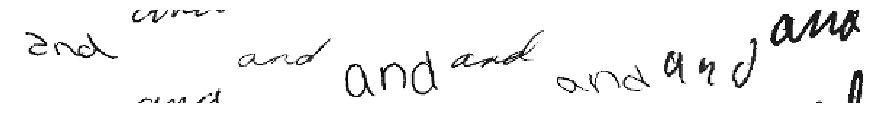

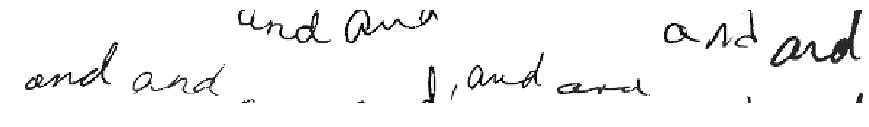

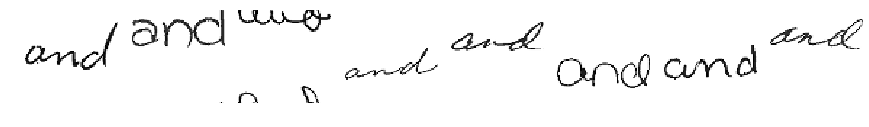

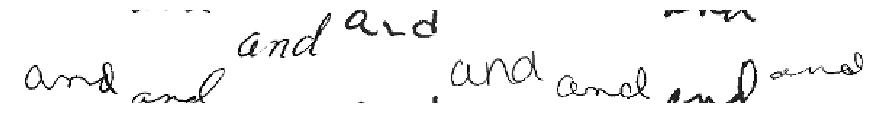

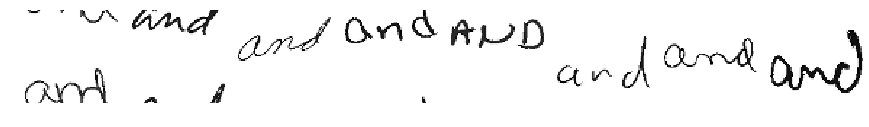

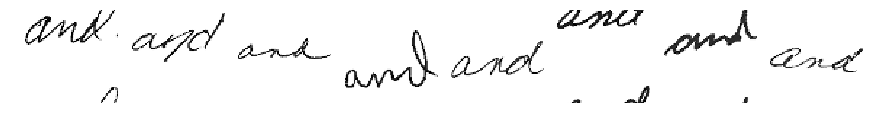

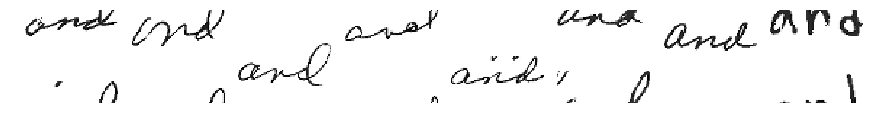

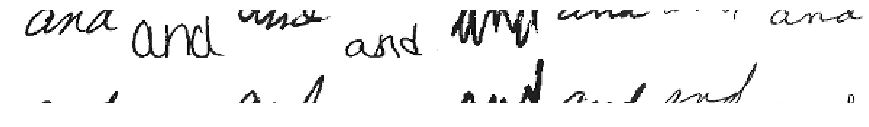

In [17]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [0]:
### ======= FOR SEEN DATASET =======

In [0]:
mc = ModelCheckpoint(filepath='simple_ae_maxpool_seen_weights_v33.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
autoencoder.load_weights('simple_ae_maxpool_seen_weights_v32 (1).h5')

In [21]:
#-- Run Each Set two times manually 
EPOCHS = 1000
Seen_hist = autoencoder.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                   ).history

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.10184, saving model to simple_ae_maxpool_seen_weights_v33.h5
Epoch 2/1000

Epoch 00002: val_loss improved from 0.10184 to 0.09816, saving model to simple_ae_maxpool_seen_weights_v33.h5
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.09816
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.09816
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.09816
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.09816
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.09816
Epoch 8/1000

Epoch 00008: val_loss improved from 0.09816 to 0.09756, saving model to simple_ae_maxpool_seen_weights_v33.h5
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.09756
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.09756
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.09756
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.09

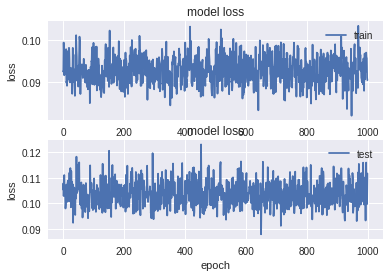

In [0]:
plt.subplot(2,1,1)
plt.plot(Seen_hist['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right') ;          
plt.subplot(2,1,2)
plt.plot(Seen_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper right');

In [0]:

test_Seen = datagen(len(val_list_of_writers),val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx_s,vy_s = next(test_Seen)

(952, 64, 64, 1) (952,)


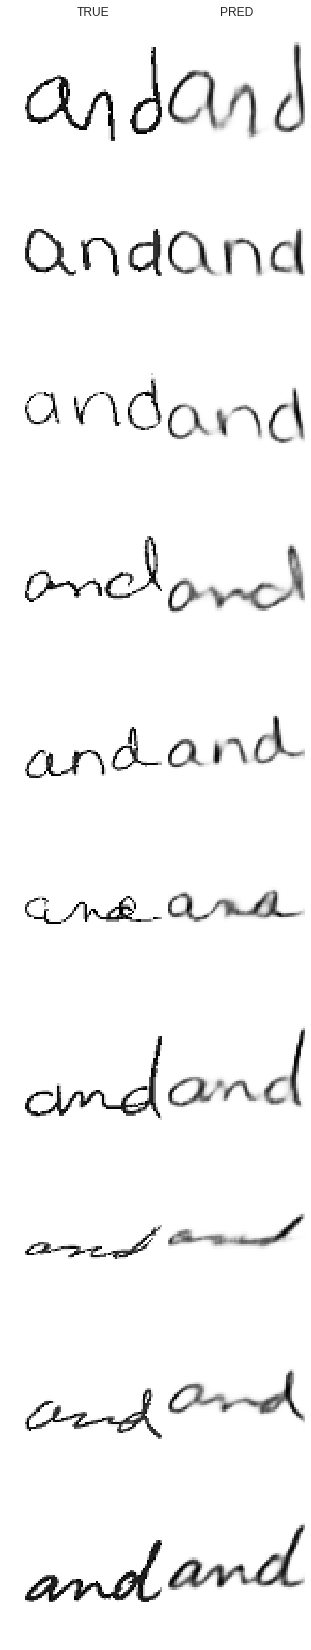

In [0]:
print(vx_s.shape,vy_s[0].shape)
py_s = autoencoder.predict(vx_s[:10])
f,ax = plt.subplots(len(vx_s[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx_s[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx_s[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py_s[i].reshape((64,64)))
    ax[i,1].axis('off')

## Latent Features

In [0]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)

In [0]:
Seen_latent = latent_Features(vx_s,vy_s)
display(Seen_latent.head(10))

,index,identity,imagename,latent
0,535,0001,0001a_num1.png,"[0.0, 0.35694602, 0.0, 0.6073017, 0.0, 0.0, 1...."
1,6,0001,0001a_num1.png,"[0.0, 0.25730813, 0.0, 0.656732, 0.0, 0.0, 1.4..."
2,726,0001,0001a_num2.png,"[0.0, 0.0, 0.0, 0.76158005, 0.0, 0.0, 2.758897..."
3,121,0002,0002a_num2.png,"[0.0, 0.0, 0.0, 0.36463323, 0.0, 0.0, 0.0, 0.0..."
4,680,0004,0004aa_num1.png,"[1.4625828, 0.29542023, 0.0, 0.7978575, 0.4808..."
5,243,0004,0004aa_num1.png,"[1.3903755, 0.095498845, 0.0, 0.8554293, 0.499..."
6,450,0005,0005aa_num1.png,"[0.34628916, 0.5847775, 0.0, 0.14361213, 0.0, ..."
7,900,0006,0006a_num1.png,"[1.5218112, 0.8850383, 0.0, 0.0, 0.0, 0.0, 0.9..."
8,17,0011,0011a_num1.png,"[0.0, 0.5745244, 0.0, 0.5406849, 0.0, 0.0, 0.6..."
9,753,0012,0012a_num1.png,"[0.0, 0.027843744, 0.12492233, 2.152031, 0.0, ..."


In [0]:
seen_cv_df = cross_validation(Seen_latent)



In [0]:
display(seen_cv_df.head(100))


,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,0001,0001a_num1.png,2,2,913,37,0,0.051282,1.000000,0.097561,0.961134,952,"[0005/0005aa_num1.png, 0009/0009a_num2.png, 00...",[]
1,0001,0001a_num1.png,2,2,913,37,0,0.051282,1.000000,0.097561,0.961134,952,"[0005/0005aa_num1.png, 0009/0009a_num2.png, 00...",[]
2,0002,0002a_num2.png,2,2,926,24,0,0.076923,1.000000,0.142857,0.974790,952,"[0008/0008a_num1.png, 0008/0008a_num1.png, 000...",[]
3,0002,0002a_num2.png,2,2,925,25,0,0.074074,1.000000,0.137931,0.973739,952,"[0008/0008a_num1.png, 0008/0008a_num1.png, 000...",[]
4,0004,0004aa_num1.png,1,1,855,96,0,0.010309,1.000000,0.020408,0.899160,952,"[0009/0009a_num1.png, 0047/0047a_num1.png, 004...",[]
5,0005,0005aa_num1.png,3,2,907,42,1,0.045455,0.666667,0.085106,0.954832,952,"[0006/0006a_num2.png, 0009/0009a_num2.png, 000...",[0005/0005a_num1.png]
6,0005,0005aa_num1.png,3,3,897,52,0,0.054545,1.000000,0.103448,0.945378,952,"[0001/0001a_num1.png, 0001/0001a_num1.png, 000...",[]
7,0005,0005a_num1.png,3,2,921,28,1,0.066667,0.666667,0.121212,0.969538,952,"[0006/0006a_num1.png, 0006/0006a_num2.png, 000...",[0005/0005aa_num1.png]
8,0006,0006a_num1.png,3,3,923,26,0,0.103448,1.000000,0.187500,0.972689,952,"[0005/0005a_num1.png, 0077/0077a_num2.png, 014...",[]
9,0006,0006a_num1.png,3,3,929,20,0,0.130435,1.000000,0.230769,0.978992,952,"[0165/0165aa_num1.png, 0178/0178a_num1.png, 01...",[]


In [0]:
seen_total = seen_cv_df.shape[0]
seen_total_images = seen_cv_df['total_images_identity']
s_tps = seen_cv_df['TP'].sum()
s_fps = seen_cv_df['FP'].sum()
s_tns = seen_cv_df['TN'].sum()
s_fns = seen_cv_df['FN'].sum()
s_precision = s_tps/(s_fps+s_tps)
s_recall = s_tps/(s_tps+s_fns)
s_f1 = 2*(s_precision*s_recall)/(s_precision+s_recall)
print('precision:',s_precision,'\nrecall:',s_recall,'\nf1:',s_f1)
s_acc = seen_cv_df['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(seen_cv_df['TP']/seen_total_images))
print('Inter Writer Accuracy (Type 2)::',s_tns/seen_total/seen_total)
print('acc:',s_acc)

precision: 0.05561259411362081 
recall: 0.9174311926605505 
f1: 0.10486830960351712
Intra Writer Accuracy (Type 1): 0.927801120448179
Inter Writer Accuracy (Type 2):: 0.9481564684697409
acc: 0.9510252630463959


In [0]:
## ===== For Unseen Dataset =======

In [0]:
un_val_path = 'unseen-dataset/ValidationSet/'
un_v_img = os.listdir(un_val_path)
len(un_v_img)
un_val_list_of_writers = un_v_img
test_Unseen = datagen(len(un_val_list_of_writers),un_val_path,un_val_list_of_writers, hshift = (-12,12), vis=True)
vx_us,vy_us = next(test_Unseen)

In [0]:
Unseen_latent = latent_Features(vx_us,vy_us)
display(Unseen_latent.head(10))

,index,identity,imagename,latent
0,61,1451,1451c_num2.png,"[0.3043914, 0.0, 0.0, 0.60574853, 0.31809163, ..."
1,68,1451,1451c_num3.png,"[1.6885803, 0.0, 0.0, 1.6653991, 0.77260756, 0..."
2,178,1451,1451c_num2.png,"[0.26501536, 0.0, 0.0, 0.6033678, 0.32535028, ..."
3,720,1451,1451c_num5.png,"[0.0, 1.7879164, 0.0, 0.0, 0.0, 0.31623954, 1...."
4,303,1451,1451c_num6.png,"[1.1546005, 1.6094418, 0.0, 0.0, 1.0044371, 1...."
5,330,1451,1451b_num3.png,"[0.12665865, 0.0, 0.0, 2.5947716, 0.0, 0.0, 0...."
6,713,1451,1451c_num2.png,"[0.018028703, 0.0, 0.0, 0.29168317, 0.5257937,..."
7,96,1451,1451c_num1.png,"[0.04424673, 0.0, 0.0, 0.7297348, 0.0, 0.0, 0...."
8,238,1451,1451c_num2.png,"[0.52263284, 0.0, 0.0, 0.36070886, 0.0, 0.0, 0..."
9,137,1452,1452c_num1.png,"[1.3440052, 2.4240868, 0.0, 0.97371465, 0.1001..."


In [0]:
Unseen_cv_df = cross_validation(Unseen_latent)

In [0]:
display(Unseen_cv_df.head(100))

,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,1451,1451c_num2.png,9,5,854,25,4,0.166667,0.555556,0.256410,0.967342,888,"[1453/1453c_num5.png, 1453/1453c_num8.png, 145...","[1451/1451c_num3.png, 1451/1451c_num5.png, 145..."
1,1451,1451c_num1.png,9,5,841,38,4,0.116279,0.555556,0.192308,0.952703,888,"[1457/1457b_num2.png, 1457/1457a_num3.png, 145...","[1451/1451c_num3.png, 1451/1451c_num5.png, 145..."
2,1451,1451c_num2.png,9,5,849,30,4,0.142857,0.555556,0.227273,0.961712,888,"[1457/1457b_num2.png, 1457/1457c_num2.png, 145...","[1451/1451c_num3.png, 1451/1451c_num5.png, 145..."
3,1451,1451b_num3.png,9,1,865,14,8,0.066667,0.111111,0.083333,0.975225,888,"[1453/1453b_num4.png, 1453/1453a_num1.png, 145...","[1451/1451c_num2.png, 1451/1451c_num3.png, 145..."
4,1451,1451c_num2.png,9,6,861,18,3,0.250000,0.666667,0.363636,0.976351,888,"[1457/1457b_num2.png, 1457/1457c_num2.png, 145...","[1451/1451c_num5.png, 1451/1451c_num6.png, 145..."
5,1451,1451c_num5.png,9,1,860,19,8,0.050000,0.111111,0.068966,0.969595,888,"[1495/1495a_num3.png, 1495/1495a_num6.png, 149...","[1451/1451c_num2.png, 1451/1451c_num3.png, 145..."
6,1451,1451c_num2.png,9,5,854,25,4,0.166667,0.555556,0.256410,0.967342,888,"[1453/1453c_num5.png, 1457/1457b_num2.png, 145...","[1451/1451c_num3.png, 1451/1451c_num5.png, 145..."
7,1451,1451c_num3.png,9,2,849,30,7,0.062500,0.222222,0.097561,0.958333,888,"[1461/1461a_num1.png, 1461/1461a_num1.png, 146...","[1451/1451c_num2.png, 1451/1451c_num2.png, 145..."
8,1451,1451c_num6.png,9,1,823,56,8,0.017544,0.111111,0.030303,0.927928,888,"[1452/1452c_num1.png, 1452/1452b_num1.png, 145...","[1451/1451c_num2.png, 1451/1451c_num3.png, 145..."
9,1452,1452c_num1.png,3,3,802,83,0,0.034884,1.000000,0.067416,0.906532,888,"[1451/1451c_num6.png, 1458/1458a_num3.png, 146...",[]


In [0]:
Unseen_total = Unseen_cv_df.shape[0]
Unseen_total_images = Unseen_cv_df['total_images_identity']
us_tps = Unseen_cv_df['TP'].sum()
us_fps = Unseen_cv_df['FP'].sum()
us_tns = Unseen_cv_df['TN'].sum()
us_fns = Unseen_cv_df['FN'].sum()
us_precision = us_tps/(us_fps+us_tps)
us_recall = us_tps/(us_tps+us_fns)
us_f1 = 2*(us_precision*us_recall)/(us_precision+us_recall)
print('precision:',us_precision,'\nrecall:',us_recall,'\nf1:',us_f1)
us_acc = Unseen_cv_df['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(Unseen_cv_df['TP']/Unseen_total_images))
print('Inter Writer Accuracy (Type 2)::',us_tns/Unseen_total/Unseen_total)
print('acc:',us_acc)

precision: 0.10878593212640322 
recall: 0.7393605292171995 
f1: 0.18966541278954663
Intra Writer Accuracy (Type 1): 0.7519302576287863
Inter Writer Accuracy (Type 2):: 0.918827611395179
acc: 0.9273318927035136


In [0]:
##===== For Shuffled Dataset

In [0]:
sh_val_path = 'shuffled-dataset/ValidationSet/'
sh_v_img = os.listdir(sh_val_path)
len(sh_v_img)
sh_val_list_of_writers = sh_v_img
test_shuffle = datagen(len(sh_val_list_of_writers),sh_val_path,sh_val_list_of_writers, hshift = (-12,12), vis=True)
vx_sh,vy_sh = next(test_shuffle)

In [25]:
shuffle_latent = latent_Features(vx_sh,vy_sh)
display(shuffle_latent.head(10))

,index,identity,imagename,latent
0,24,0001,0001a_num4.png,"[0.0, 0.74423164, 0.0, 0.27809608, 0.0, 0.0, 1..."
1,374,0001,0001c_num3.png,"[0.04421193, 0.78650826, 0.0, 0.0, 0.0, 0.0, 2..."
2,1452,0001,0001a_num3.png,"[0.0, 0.15646122, 0.0, 0.061453696, 0.0, 0.0, ..."
3,843,0001,0001a_num4.png,"[0.0, 0.43039858, 0.0, 0.28877217, 0.0, 0.0, 1..."
4,36,0001,0001a_num5.png,"[0.0, 0.0, 0.0, 0.32436904, 0.0, 0.0, 1.062553..."
5,1833,0001,0001c_num1.png,"[0.0, 0.9140325, 0.0, 0.0, 0.0, 0.0, 1.392689,..."
6,568,0001,0001c_num2.png,"[0.0, 1.2581954, 0.0, 1.0117791, 0.0, 0.0, 1.5..."
7,759,0001,0001c_num2.png,"[0.0, 1.0506696, 0.0, 0.9762862, 0.0, 0.0, 1.6..."
8,291,0001,0001c_num2.png,"[0.0, 1.0291327, 0.0, 0.9628397, 0.0, 0.0, 1.7..."
9,1668,0002,0002c_num2.png,"[0.0, 0.9399559, 0.0, 0.0, 0.0, 0.0, 1.1437967..."


In [26]:
shuffle_cv_df = cross_validation(shuffle_latent)


In [29]:
shuffle_total = shuffle_cv_df.shape[0]
shuffle_total_images = shuffle_cv_df['total_images_identity']
sh_tps = shuffle_cv_df['TP'].sum()
sh_fps = shuffle_cv_df['FP'].sum()
sh_tns = shuffle_cv_df['TN'].sum()
sh_fns = shuffle_cv_df['FN'].sum()
sh_precision = sh_tps/(sh_fps+sh_tps)
sh_recall = sh_tps/(sh_tps+sh_fns)
sh_f1 = 2*(sh_precision*sh_recall)/(sh_precision+sh_recall)
print('precision:',sh_precision,'\nrecall:',sh_recall,'\nf1:',sh_f1)
sh_acc = shuffle_cv_df['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(shuffle_cv_df['TP']/shuffle_total_images))
print('Inter Writer Accuracy (Type 2)::',sh_tns/shuffle_total/shuffle_total)
print('acc:',sh_acc)

precision: 0.03477987783031595 
recall: 0.8405130946018172 
f1: 0.06679578990290272
Intra Writer Accuracy (Type 1): 0.8712105556093377
Inter Writer Accuracy (Type 2):: 0.9414207685719956
acc: 0.9434447896323159
